### Development with what we have learned so far

In the <a href='https://jovian.ml/erelin6613/air-pollution-case'>first part</a> of this project we explored different approaches to model sequences of metrics regarding S02 emissions. After basic EDA and simple modeling we will be building a smarter model.

Although convolutional network seem to give better results at first, after some experimenting I discovered it is not as good as recurrent stateful model. So here is what we will be bulding. But first we need to replicate the setup we have got before.

#### Setup repication

In [1]:
# !pip3 install git+https://github.com/Kaggle/kaggle-api.git --upgrade

In [104]:
!pip3 install jovian --quiet

In [105]:
def setup_local(kaggle_creds='kaggle.json'):
    import os
    import json
    with open(kaggle_creds, 'r') as f:
        creds = json.loads(f.read())
    os.environ['KAGGLE_USERNAME']=creds['username']
    os.environ['KAGGLE_KEY']=creds['key']
    os.system('kaggle datasets download -d so2-emissions-daily-summary-data')
    os.system('unzip so2-emissions-daily-summary-data.zip')
    return ''

# provide a kaggle.json credentials and
# uncomment the line if you run localy
#
# data_dir = setup_local()

In [106]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.nn.functional as F
from torch.optim import Adam
import jovian
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from tqdm import tqdm
#from category_encoders import Label
# jovian.commit(project=project_name)

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5);

<IPython.core.display.Javascript object>

In [107]:
project_name = 'air-pollution-case-p2'
author = 'Valentyna Fihurska'

In [108]:
try:
    data_dir
except Exception:
    data_dir = '../input/so2-emissions-daily-summary-data/'
pol_df = pd.read_csv(os.path.join(data_dir, 'daily_42401_2017/daily_42401_2017.csv'))
p2018 = pd.read_csv(os.path.join(data_dir, 'daily_42401_2018.csv'))
p2019 = pd.read_csv(os.path.join(data_dir, 'daily_42401_2019.csv'))
pol_df = pol_df.loc[(pol_df['County Code']==101) & (pol_df['State Code']==42)]
p2018 = p2018.loc[(p2018['County Code']==101) & (p2018['State Code']==42)]
p2019 = p2019.loc[(p2019['County Code']==101) & (p2019['State Code']==42)]
pol_df = pd.concat([pol_df, p2018, p2019], axis=0)
del p2018, p2019

In [148]:
to_drop = ['State Code', 'County Code', 'Site Num', 
           'Parameter Code', 'Latitude', 'Longitude',
          'Parameter Name', 'Sample Duration', 
           'Pollutant Standard']
df = pol_df.drop(to_drop, axis=1)
df.drop(['Datum', 'Units of Measure', 'Event Type', 
         'State Name', 'County Name', 'City Name',
        'CBSA Name'], axis=1, inplace=True)
df.loc[:, 'Date Local'] = pd.to_datetime(df['Date Local'])
df.set_index('Date Local', inplace=True)
df = df.loc[(df['Address']==df['Address'].unique()[0]) & (
    df['Method Name']==df['Method Name'].unique()[0])]
df.drop(['Address', 'Method Name', 'Method Code', 'Local Site Name', 
         'Date of Last Change', 'POC', 'Observation Count', 
         'Observation Percent', '1st Max Hour'], axis=1, inplace=True)
df

,Arithmetic Mean,1st Max Value,AQI
Date Local,,,
2017-01-01,1.720833,2.5,3.0
2017-01-02,1.204545,1.7,1.0
2017-01-03,1.254167,1.5,1.0
2017-01-04,2.173684,6.9,9.0
2017-01-05,1.820833,2.9,3.0
...,...,...,...
2019-12-27,0.760870,1.3,1.0
2019-12-28,0.878261,2.5,3.0
2019-12-29,0.960870,2.6,3.0


In [149]:
def save_n_commit(model, metrics=None):
    
    kw = ['arch', 'epochs', 'lr', 
          'scheduler', 'weight_decay', 
          'grad_clip', 'opt', 'val_loss',
          'val_score', 'train_loss', 
          'train_time', 'loss_func']
    
    if metrics:
        for k in kw:
            try:
                metrics[k]
            except Exception:
                metrics[k] = None
    else:
        metrics = {k: None for k in kw}
    
    weights_fname = '{}-{}ep-{}lr.pth'.format(metrics['arch'],
                                              metrics['epochs'],
                                              metrics['lr'])
    torch.save(model.state_dict(), weights_fname)
    jovian.reset()

    jovian.log_hyperparams(arch=metrics['arch'], 
                           epochs=metrics['epochs'], 
                           lr=metrics['lr'], 
                           scheduler=metrics['scheduler'], 
                           weight_decay=metrics['weight_decay'], 
                           grad_clip=metrics['grad_clip'],
                           opt=metrics['opt'],
                           val_loss=metrics['val_loss'],
                           val_score=metrics['val_score'],
                           train_loss=metrics['train_loss'],
                           train_time=metrics['train_time'],
                          loss_func=metrics['loss_func'])
    
    jovian.commit(project=project_name, 
                  environment=None, 
                  outputs=[weights_fname])
    return True

In [150]:
def get_sequences(df, seq_len):
    xs = []
    ys = []
    for i in range(len(df)-seq_len-1):
        x = df[i:(i+seq_len)].values
        y = df.loc[df.index[i+seq_len]]#.values
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

Something we did not do before but worth to note. Our values in columns are not exactly normaly distributed. Although it might introduce some difficulties to our model, it should not be too strikingly bad.

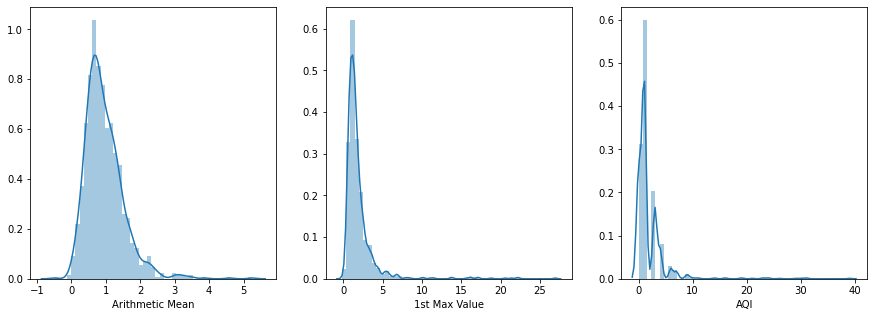

In [151]:
def plot_dist(df):
    fig, ax = plt.subplots(1, len(df.columns))
    for i, col in zip(range(len(df.columns)), 
                      df.columns):
        sns.distplot(df[col], ax=ax[i], axlabel=col)

plot_dist(df)

In [152]:
def log_scale(df, invert=False):
    for col in df.columns:
        if invert:
            df.loc[:, col] = np.exp(df[col]) #- 1
            continue
        df.loc[:, col] = np.log1p(df[col])
    return df

In [153]:
class PollutionDataset(Dataset):
    
    def __init__(self, frame, window=14):
        super().__init__()
        self.frame = frame
        self.window = window
        self.x, self.y = get_sequences(self.frame,
                            seq_len=self.window)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, ind):
        x = np.array(self.x[ind])
        y = np.array(self.y[ind])
        return torch.tensor(x), torch.tensor(y)
    
    def stationary_conversion(self):
        self.frame = self.frame.diff()
        print(self.frame)
    
    def scale_features(self, scaler='custom'):
        if scaler == 'custom':
            scalers = self.get_scalers()
            for i in range(len(self.frame.columns)):
                col = self.frame.columns[i]
                self.frame.loc[:, col] = self.frame[col]/scalers[i]
            return
        scalers = []
        for col in self.frame.columns:
            if scaler=='standart':
                sc = StandardScaler()
            if scaler=='minmax':
                sc = MinMaxScaler()
            sc.fit(self.frame[col].values.reshape(-1, 1))
            self.frame.loc[:, col] = sc.transform(
                self.frame[col].values.reshape(-1, 1))
            scalers.append(sc)
        self.scalers = scalers
        
    def get_scalers(self):
        scalers = list()
        scalers.append(self.frame[self.frame.columns[0]].values.max())
        scalers.append(self.frame[self.frame.columns[1]].values.max())
        scalers.append(self.frame[self.frame.columns[2]].values.max())
        self.scalers = scalers
        return self.scalers
        

There are some difficulties I did not figure out how to resolve efficiently:
* the data is not stationary and multiple differencing does not work to make it such
* usual scaling technics also did not work as expected, more so it made models perform worse

As a result you will see model is not going to be a magic ball. It perform quite great to predict the dynamic complonent of the behivor of data points but it lacks a component of scale. For now I will leave it as it is but as I learn more about time series prediction methods I might improve it in the future. 

In [154]:
train_size = int(0.85*len(df))
train_set = PollutionDataset(df[:train_size])
val_set = PollutionDataset(df[train_size:])

In [155]:
class BaseModel(nn.Module):
    
    def training_step(self, x, y, loss_f=F.mse_loss):
        x, y = x.float(), y.float()
        out = self(x)
        #print(out)
        loss = loss_f(out, y)      
        return loss
    
    def validation_step(self, x, y, loss_f=F.mse_loss):
        x, y = x.float(), y.float()
        out = self(x)
        loss = loss_f(out, y)
        return {'val_loss': loss.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {}, train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

In [156]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

I decided to build LSTM model and here what's new to it:
* model has two LSTM model embedded inside
* it captures a state, i.e. in the process of fitting/evaluating it relies on both input and "memory" of what it saw before

In [157]:
class StatefulModel(BaseModel):
    
    def __init__(self, n_features, n_hidden, seq_len=14, 
                 n_layers=2, out_features=1):
        super().__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.init_hidden()
        self.lstm1 = nn.LSTM(n_features, 
                            n_hidden, 
                            n_layers,
                            dropout=0.5)
        self.lstm2 = nn.LSTM(n_hidden, 
                            n_hidden, 
                            n_layers,
                            dropout=0.5)
        self.linear = nn.Linear(n_hidden, out_features)
    
    def init_hidden(self):
        self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                       torch.zeros(self.n_layers, self.seq_len, self.n_hidden))
    
    def forward(self, x):
        x = x.view(1, self.seq_len, -1).float()
        #print(x.view(1, self.seq_len, -1))
        lstm_out, self.hidden = self.lstm1(x, self.hidden)
        lstm_out, self.hidden = self.lstm2(lstm_out, 
                                           self.hidden)
        last_time_step = lstm_out.view(
            self.seq_len, len(x), self.n_hidden)[-1]
        #last_time_step = torch.flatten(last_time_step)
        x = self.linear(last_time_step)
        #print(x)
        self.hidden = self.hidden[0].detach(), self.hidden[1].detach()
        return torch.flatten(x)

In [168]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(model, train_set, val_set, subset, epochs=10, 
        lr=1e-4, loss_f=F.mse_loss, save=False):
    
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-06)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
                                                 base_lr=lr, 
                                                 max_lr=1e-6, 
                                                 step_size_up=int(len(train_set)/2),
                                                 step_size_down=int(len(train_set)/2),
                                                 cycle_momentum=False)
    model.train()
    outputs = []
    for epoch in range(epochs):
        total_loss = []
        lrs = []
        for each in tqdm(train_set):
            x, y = each
            x = x.T[subset]
            #x = x.view(1, 30, -1)
            y = y[subset].view(1, )
            #print(x, y)
            model.zero_grad()
            loss = model.training_step(x, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            lrs.append(get_lr(optimizer))
            total_loss.append(loss.item())
            optimizer.zero_grad()
            
        t_loss = np.array(total_loss).mean()
        print('Epoch: {}, loss: {}, last lr: {}'.format(
            epoch, t_loss, lrs[-1]))
    if save:
        save_n_commit(model, metrics={'arch': str(model),
                                     'epochs': epochs,
                                      'last_lr': lrs[-1],
                                     'loss_func': loss_f.__name__,
                                     'opt': str(optimizer),
                                     'train_loss': t_loss})
    return model

In [169]:
model_am = StatefulModel(1, 512)
model_mv = StatefulModel(1, 512)
model_aqi = StatefulModel(1, 512)

In [ ]:
fit(model_am, train_set, val_set, 0, save=True)
fit(model_mv, train_set, val_set, 1, save=True)
fit(model_aqi, train_set, val_set, 2, save=True)

  0%|          | 2/895 [00:00<00:52, 16.93it/s]

Epoch: 0, loss: 0.48310167139818405, last lr: 9.977852348993289e-05


  0%|          | 2/895 [00:00<01:06, 13.38it/s]

Epoch: 1, loss: 0.29317990333665483, last lr: 9.955704697986577e-05


  0%|          | 2/895 [00:00<00:52, 17.05it/s]

Epoch: 2, loss: 0.28670134913114864, last lr: 9.933557046979874e-05


  0%|          | 2/895 [00:00<00:52, 17.02it/s]

Epoch: 3, loss: 0.28186627208426607, last lr: 9.911409395973153e-05


  0%|          | 2/895 [00:00<00:51, 17.18it/s]

Epoch: 4, loss: 0.2764039674478572, last lr: 9.88926174496645e-05


  0%|          | 2/895 [00:00<00:52, 17.10it/s]

Epoch: 5, loss: 0.2755861152003583, last lr: 9.86711409395973e-05


  0%|          | 2/895 [00:00<00:52, 16.94it/s]

Epoch: 6, loss: 0.2661724664135838, last lr: 9.844966442953027e-05


  0%|          | 2/895 [00:00<01:08, 13.08it/s]

Epoch: 7, loss: 0.25808859930711386, last lr: 9.822818791946307e-05


  0%|          | 2/895 [00:00<00:52, 17.16it/s]

Epoch: 8, loss: 0.25366962257932346, last lr: 9.800671140939587e-05


100%|██████████| 895/895 [01:00<00:00, 14.69it/s]

Epoch: 9, loss: 0.2509717957337152, last lr: 9.7785234899329e-05
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: 

········
[jovian] Hyperparams logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/erelin6613/air-pollution-case-p2


<IPython.core.display.Javascript object>

  0%|          | 2/895 [00:00<00:51, 17.22it/s]

Epoch: 0, loss: 6.730876391262315, last lr: 9.977852348993289e-05


  0%|          | 2/895 [00:00<01:09, 12.79it/s]

Epoch: 1, loss: 6.075780630219318, last lr: 9.955704697986577e-05


  0%|          | 2/895 [00:00<01:08, 13.02it/s]

Epoch: 2, loss: 6.055113125333877, last lr: 9.933557046979874e-05


  0%|          | 2/895 [00:00<01:07, 13.17it/s]

Epoch: 3, loss: 6.0139035555967135, last lr: 9.911409395973153e-05


  0%|          | 2/895 [00:00<00:48, 18.25it/s]

Epoch: 4, loss: 5.904588984592562, last lr: 9.88926174496645e-05


 52%|█████▏    | 468/895 [00:31<00:31, 13.41it/s]

In [ ]:
def evaluate(model, val_set, subset, return_preds=True):
    #x, y = val_set
    diviance = []
    model.eval()
    if return_preds:
        preds = []
    for each in tqdm(val_set):
        x, y = each
        x = x.T[subset].float()
        y = torch.tensor(y[subset]).view(1, )
        out = model(x).detach().item()
        if return_preds:
            preds.append(out)
        diviance.append(np.abs(out-y))
    mean_div = np.array(diviance).mean()

    if return_preds:
        return mean_div, np.array(preds)
    return mean_div

In [ ]:
mean_div_am, preds_am = evaluate(
    model_am, val_set, 0)
mean_div_mv, preds_mv = evaluate(
    model_mv, val_set, 1)
mean_div_aqi, preds_aqi = evaluate(
    model_aqi, val_set, 2)
preds_am

In [ ]:
scalers = train_set.get_scalers()
preds_am = scalers[0]*preds_am
preds_mv = scalers[1]*preds_mv
preds_aqi = scalers[2]*preds_aqi

true_am = np.array([val_set[i][1][0] for i in range(len(val_set))])
true_mv = np.array([val_set[i][1][1] for i in range(len(val_set))])
true_aqi = np.array([val_set[i][1][2] for i in range(len(val_set))])

In [ ]:
for i in range(1, len(preds_am)):
    print('true:', true_am[i-1], '\tpredicted:', preds_am[i])
    if i > 10:
        break

In [ ]:
plt.plot(true_am)
plt.plot(preds_am)

In [ ]:
for i in range(1, len(preds_mv)):
    print('true:', true_mv[i-1], '\tpredicted:', preds_mv[i])

In [ ]:
plt.plot(true_mv)
plt.plot(preds_mv)

In [ ]:
for i in range(1, len(preds_am)):
    print('true:', true_aqi[i-1], '\tpredicted:', preds_aqi[i])
    if i > 10:
        break

In [ ]:
for i in range(1, len(preds_aqi)):
    print('true:', true_aqi[i-1], '\tpredicted:', preds_aqi[i])
    if i > 10:
        break

In [ ]:
plt.plot(true_aqi)
plt.plot(preds_aqi)

The bottomline here is that we succesfully build a model which can predict the dynamics of the SO2 emissions. However, the time series prediction task is not an easy challange. Perphaps, our task would be even better modeled with such mathematical model as ARIMA but of course there is a lot of hand-work (or grid-search) tuning and hyperparameter search involved. The remaining issue we have in our task is scaling, i.e. we know when to expect big spikes in emissions but by how much question cannot be answered with high certainty.

For now it concludes my project for <a href='https://jovian.ml/forum/c/pytorch-zero-to-gans/18'>Deep Learning with PyTorch: Zero to GANs</a> for now but not forever. The knowldge of PyTorch solidified for me know but by no means I know everything (luckily it has a great documentation). Thanks a lot <a href='https://www.freecodecamp.org/'>FreeCodeCamp</a> and <a href='https://jovian.ml'>JovianML</a> for the opportunity to grow!

In [ ]:
import jovian
jovian.commit(project=project_name, environment=None)